# EVALUATING CLOSED LOOP SYSTEMS

This notebook is a companion to the slides for understanding closed loop systems.

# Preliminaries

In [33]:
!pip install -q control
!pip install -q tellurium
!pip install -q controlSBML

import collections
import control
import controlSBML as ctl
from IPython.display import HTML, Math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sympy
import tellurium as te

In [2]:
TIMES = ctl.makeSimulationTimes(0, 5, 500)

# Helpers

In [3]:
def plotStep(tf, is_plot=True):
    """
    Plots a transfer function step response
    
    Parameters
    ----------
    tf: control.TransferFunction
    """
    result = control.forced_response(tf, T=TIMES, U=1)
    if is_plot:
        plt.plot(result.t, result.outputs)

# TESTS
Gs = control.TransferFunction([2], [1, 3])
plotStep(Gs, is_plot=False)
print("OK!")

OK!


In [4]:
def pp(obj):
    """
    Does a LaTex rendering of an object with a latex representation.

    Parameters
    ----------
    obj: object
    """
    display(Math(str(obj)))

# Tests
pp(r"e^{\alpha}")

<IPython.core.display.Math object>

In [5]:
# Constants
CONSTANT_DCT = {"k1": 1, "k2": 2, "k3": 3, "k4": 4}
s = sympy.Symbol("s")
REF = 10

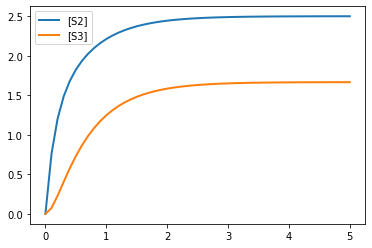

In [6]:
MODEL = """
$S1 -> S2; k1*$S1
J1: S2 -> S3; k2*S2
J2: S3 -> S2; k3*S3
J3: S2 -> ; k4*S2

k1 = 0
k2 = 0
k3 = 0
k4 = 0
$S1 = 10
S2 = 0
S3 = 0
S4 = 0
"""
RR = te.loada(MODEL)
for k in CONSTANT_DCT.keys():
    RR[k] = CONSTANT_DCT[k]
RR.simulate()
RR.plot()


<img src="https://github.com/joseph-hellerstein/advanced-controls-lectures/blob/main/Lecture_13_14-Closed-Loop-Systems/Closed-Loop-Transfer-Function.png?raw=true"
     alt="Markdown Monster icon" width=600pt
     style="float: left; margin-right: 10px;" />

<img src="https://github.com/joseph-hellerstein/advanced-controls-lectures/blob/main/Lecture_13_14-Closed-Loop-Systems/Transfer-Functions.png?raw=true"
     alt="Markdown Monster icon" width=300pt
     style="float: left; margin-right: 10px;" />

We are going to control ``S3`` by changing ``S2``. That is, $U(s) = S_2  (s)$
and $Y(s) = S_3 (s)$.

In [7]:
ctlsb = ctl.ControlSBML(RR,  input_names=["S2"], output_names=["S3"])

In [8]:
sys = ctlsb.makeNonlinearIOSystem("sys")

In [9]:
ctlsb.makeStateSpace()

StateSpace(array([[-3.]]), array([[2.]]), array([[1.]]), array([[0.]]))

In [10]:
def controller_outfcn(_, __, u, param_dct):
    k = param_dct.get("k", 2)
    ref = param_dct.get("ref", REF)
    return k*([REF] - u[0])
#
controller = control.NonlinearIOSystem(
    None, controller_outfcn, inputs=['in'], outputs=['out'],
    name="controller")

In [11]:
# Create the closed loop system
closed_loop = control.interconnect(
  [sys, controller],       # systems
  connections=[
    ['sys.S2', 'controller.out'],
    ['controller.in',  'sys.S3'],
  ],
  inplist=["controller.in"],
  outlist=["sys.S2", "sys.S3"],
)

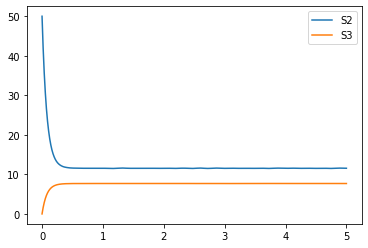

In [12]:
param_dct = {"k": 5, "ref": REF}
result = control.input_output_response(closed_loop, T=TIMES, params=param_dct)
plt.plot(TIMES, result.outputs[0], TIMES, result.outputs[1])
plt.legend(["S2", "S3"])

In [13]:
result.outputs[1][-2:]

array([7.68988725, 7.68994905])

In [14]:
type(control.feedback(controller, sys))

control.iosys.InterconnectedSystem

The output is biased! We wanted $S_3$ to be 10, but it's 7.6.

# Closed Loop Transfer Functions

<img src="https://github.com/joseph-hellerstein/advanced-controls-lectures/blob/main/Lecture_13_14-Closed-Loop-Systems/Closed-Loop-System.png?raw=true"
     alt="Markdown Monster icon" width=600pt
     style="float: left; margin-right: 10px;" />

**Transfer Functions**
\begin{eqnarray}
H_{RY}(s) & = & \frac{Y(s)}{R(s)} & = & \frac{C(s) G(s)}{1 + C(s) G(s) F(s)} \\
H_{RE}(s) & = & \frac{E(s)}{R(s)} & = & \frac{1}{1 + C(s) G(s) F(s)} \\
H_{NY}(s) & = & \frac{Y(s)}{N(s)} & = & -\frac{ F(s)}{1 + C(s) G(s) F(s)} \\
H_{DY}(s) & = & \frac{Y(s)}{D(s)} & = & \frac{ C(s)}{1 + C(s) G(s) F(s)} \\
\end{eqnarray}

# Problem Statement

We want to evaluate the transfer functions for a variety of systems $C(s)$ and filters $F(s)$.
We will use $G(s) = \frac{2}{s + 3}$, $C(s) = k_p$, and $F(s) = \frac{k_f}{s + k_f}$.

1. Create an experimental infrastructure, codes that creates a plot with a line for each of the transfer functions. You wil need to create the transfer functions C(s), G(s), F(s). The plot should have a legend.
    1. Inputs: G_tf (transfer function for G(s)), k_p, k_f
1. Construct 4 plots such that $k_p \in \{1, 10\}$, $k_f \in \{1, 10\}$.
1. Discuss the tradeoffs between large and small values of $k_p$, $k_f$?

# Experimental Infrastructure

In [35]:
def plotTFs(Gs, k_p, k_f, times=TIMES, ylim=None, title=None, is_plot=True):
    """
    Constructs the transfer functions for the proportional controller, and filter.
    Calculates the transfer functions HRYs, HREs, HNYs, HDYs and plots them.
    
    Parameters
    ----------
    Gs: control.TransferFunction
    k_pf: float
    k_f: float
    times: list-float
    ylim: (float, float)
        limits of y-values
    title: str
    
    Returns
    -------
    dct
        key: name of transfer function
        value: control.TransferFunction
    """
    Cs = control.TransferFunction([k_p], [1])
    Fs = control.TransferFunction([k_f], [1, k_f])
    denom = 1 + Cs*Gs*Fs
    # Construct the transfer functions
    tf_dct = {
        "HRYs": Cs*Gs/denom,
        "HREs": 1/denom,
        "HNYs": -Fs/denom,
        "HDYs": Cs/denom,
    }
    # Construct the plots
    _, ax = plt.subplots(1)
    for tf in tf_dct.values():
        result = control.forced_response(tf, T=TIMES, U=1)
        ax.plot(times, result.outputs)
    ax.plot([0, times[-1]], [1, 1], linestyle="--")
    ax.plot([0, times[-1]], [0, 0], linestyle="--")
    ax.legend(tf_dct.keys())
    ax.set_ylabel("value")
    ax.set_xlabel("time")
    if ylim is not None:
        ax.set_ylim(ylim)
    if title is not None:
        ax.set_title(title)
    if not is_plot:
        plt.close()
    return tf_dct
    
# Tests
Gs = control.TransferFunction([2], [1, 3])
dct = plotTFs(Gs, 10, 10, ylim=[0, 3], title="Example", is_plot=False)
print("OK!")

OK!


# Plots

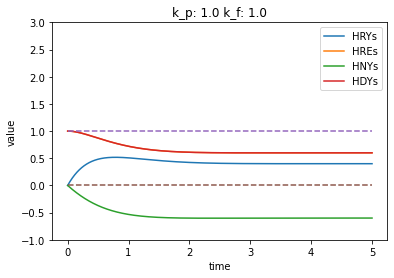

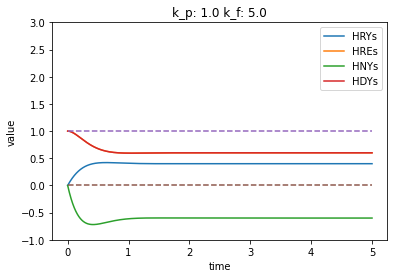

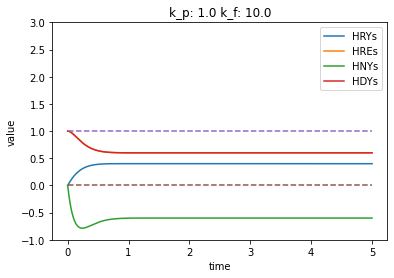

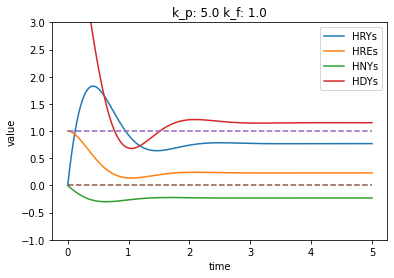

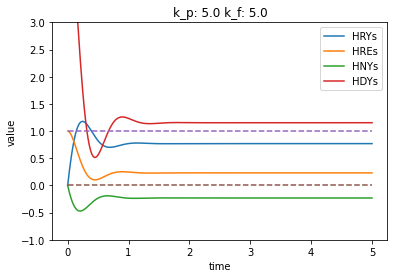

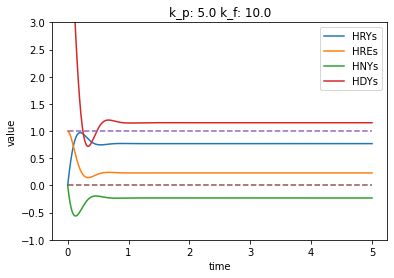

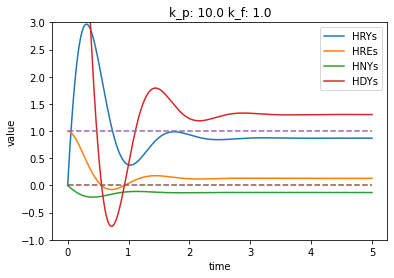

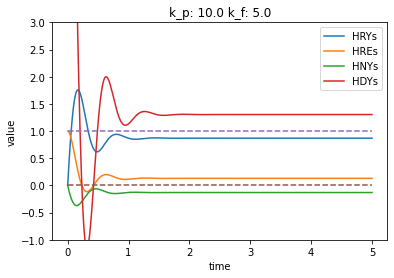

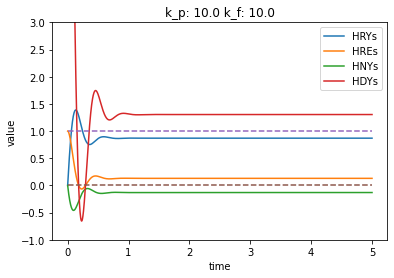

In [40]:
for k_p in [1, 5, 10]:
    for k_f in [1, 5, 10]:
        title = "k_p: %2.1f k_f: %2.1f" % (k_p, k_f)
        _ = plotTFs(Gs, k_p, k_f, title=title, ylim=[-1, 3])

# Discussion